In [1]:
from graphdatascience import GraphDataScience
import pandas as pd
from sklearn.metrics import silhouette_score

In [2]:
gds = GraphDataScience("bolt://localhost:7687", auth=('neo4j', 'password'))
gds.set_database("neo4j")

# Create a toy graph

In [3]:
gds.run_cypher("""
UNWIND range(1, 7) as nodeId
MERGE (n:Node {id:nodeId})
""")

""


In [4]:
edge_list = [[1, 2], [1, 3], [2, 3], [3, 4], [4, 5], [4, 6], [4, 7], [5, 6], [5, 7]]

In [5]:
gds.run_cypher("""
UNWIND $edgeList as pair
MATCH (s {id:pair[0]}), (t {id:pair[1]})
MERGE (s)-[:RELATES_TO]->(t)
""", {"edgeList": edge_list})

""


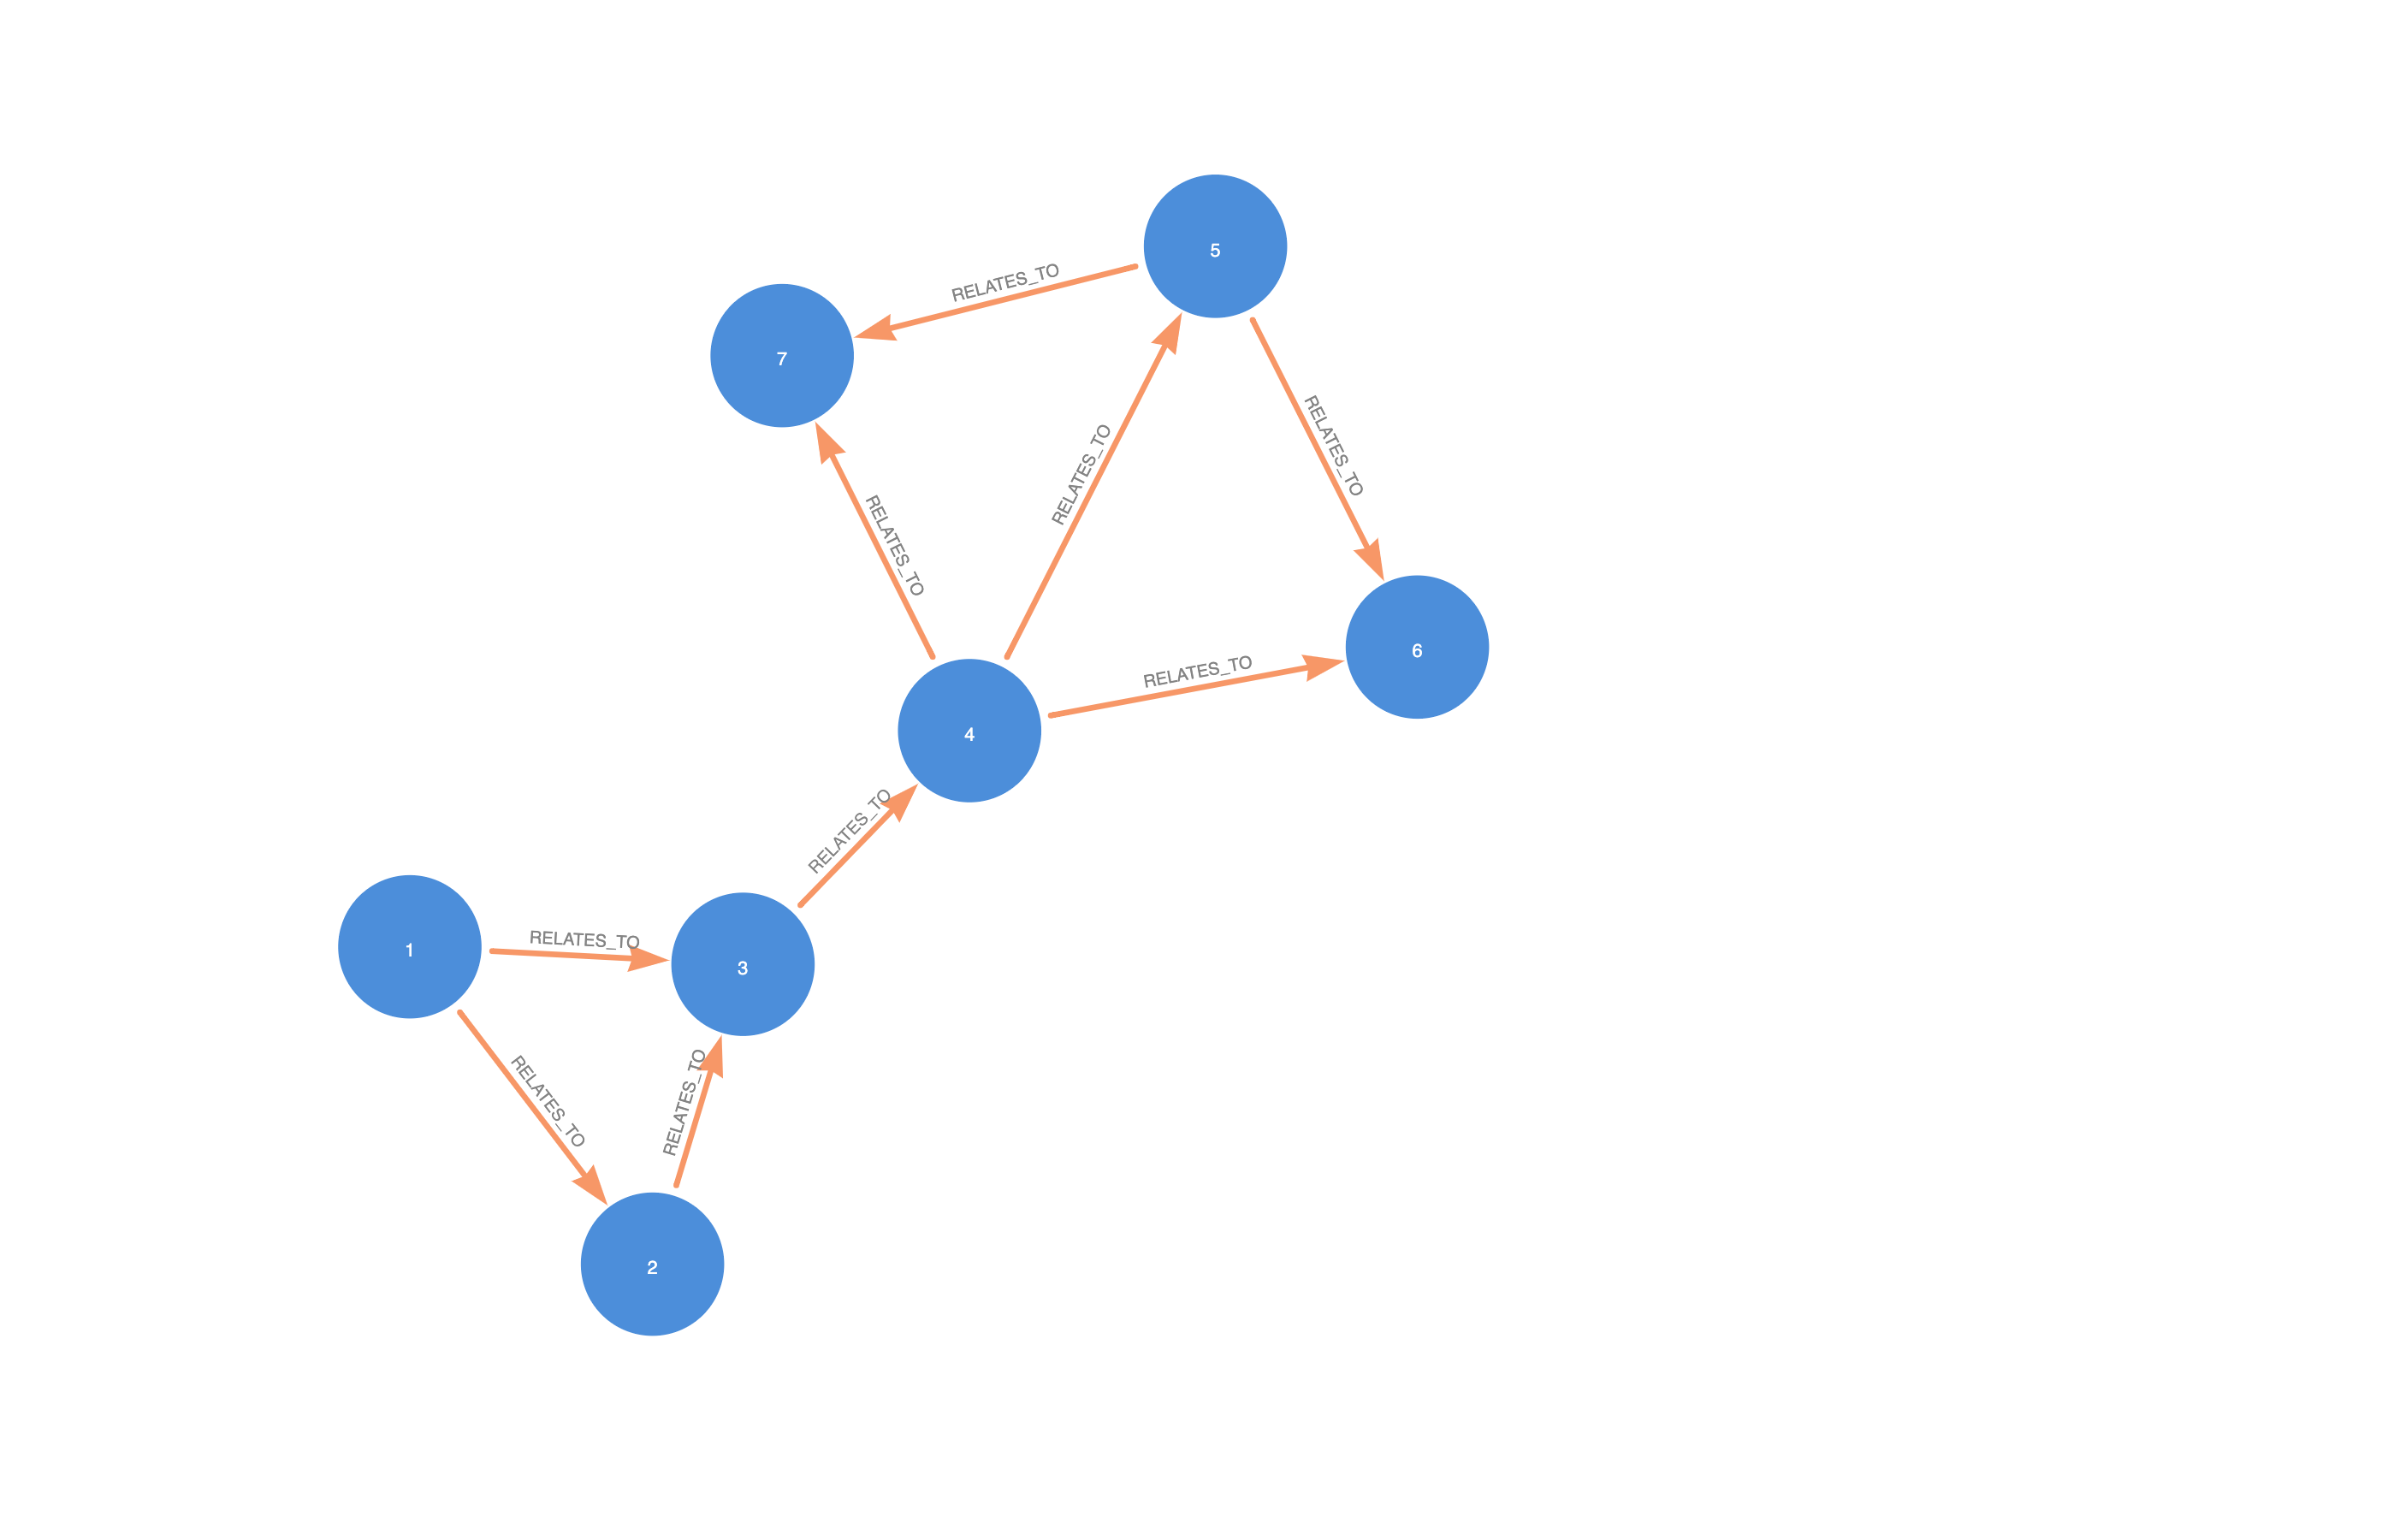

## Set clusters by visual examination

In [6]:
gds.run_cypher("""
MATCH (n)
SET n.cluster = case when n.id < 4 then 1 else 2 end
""")

""


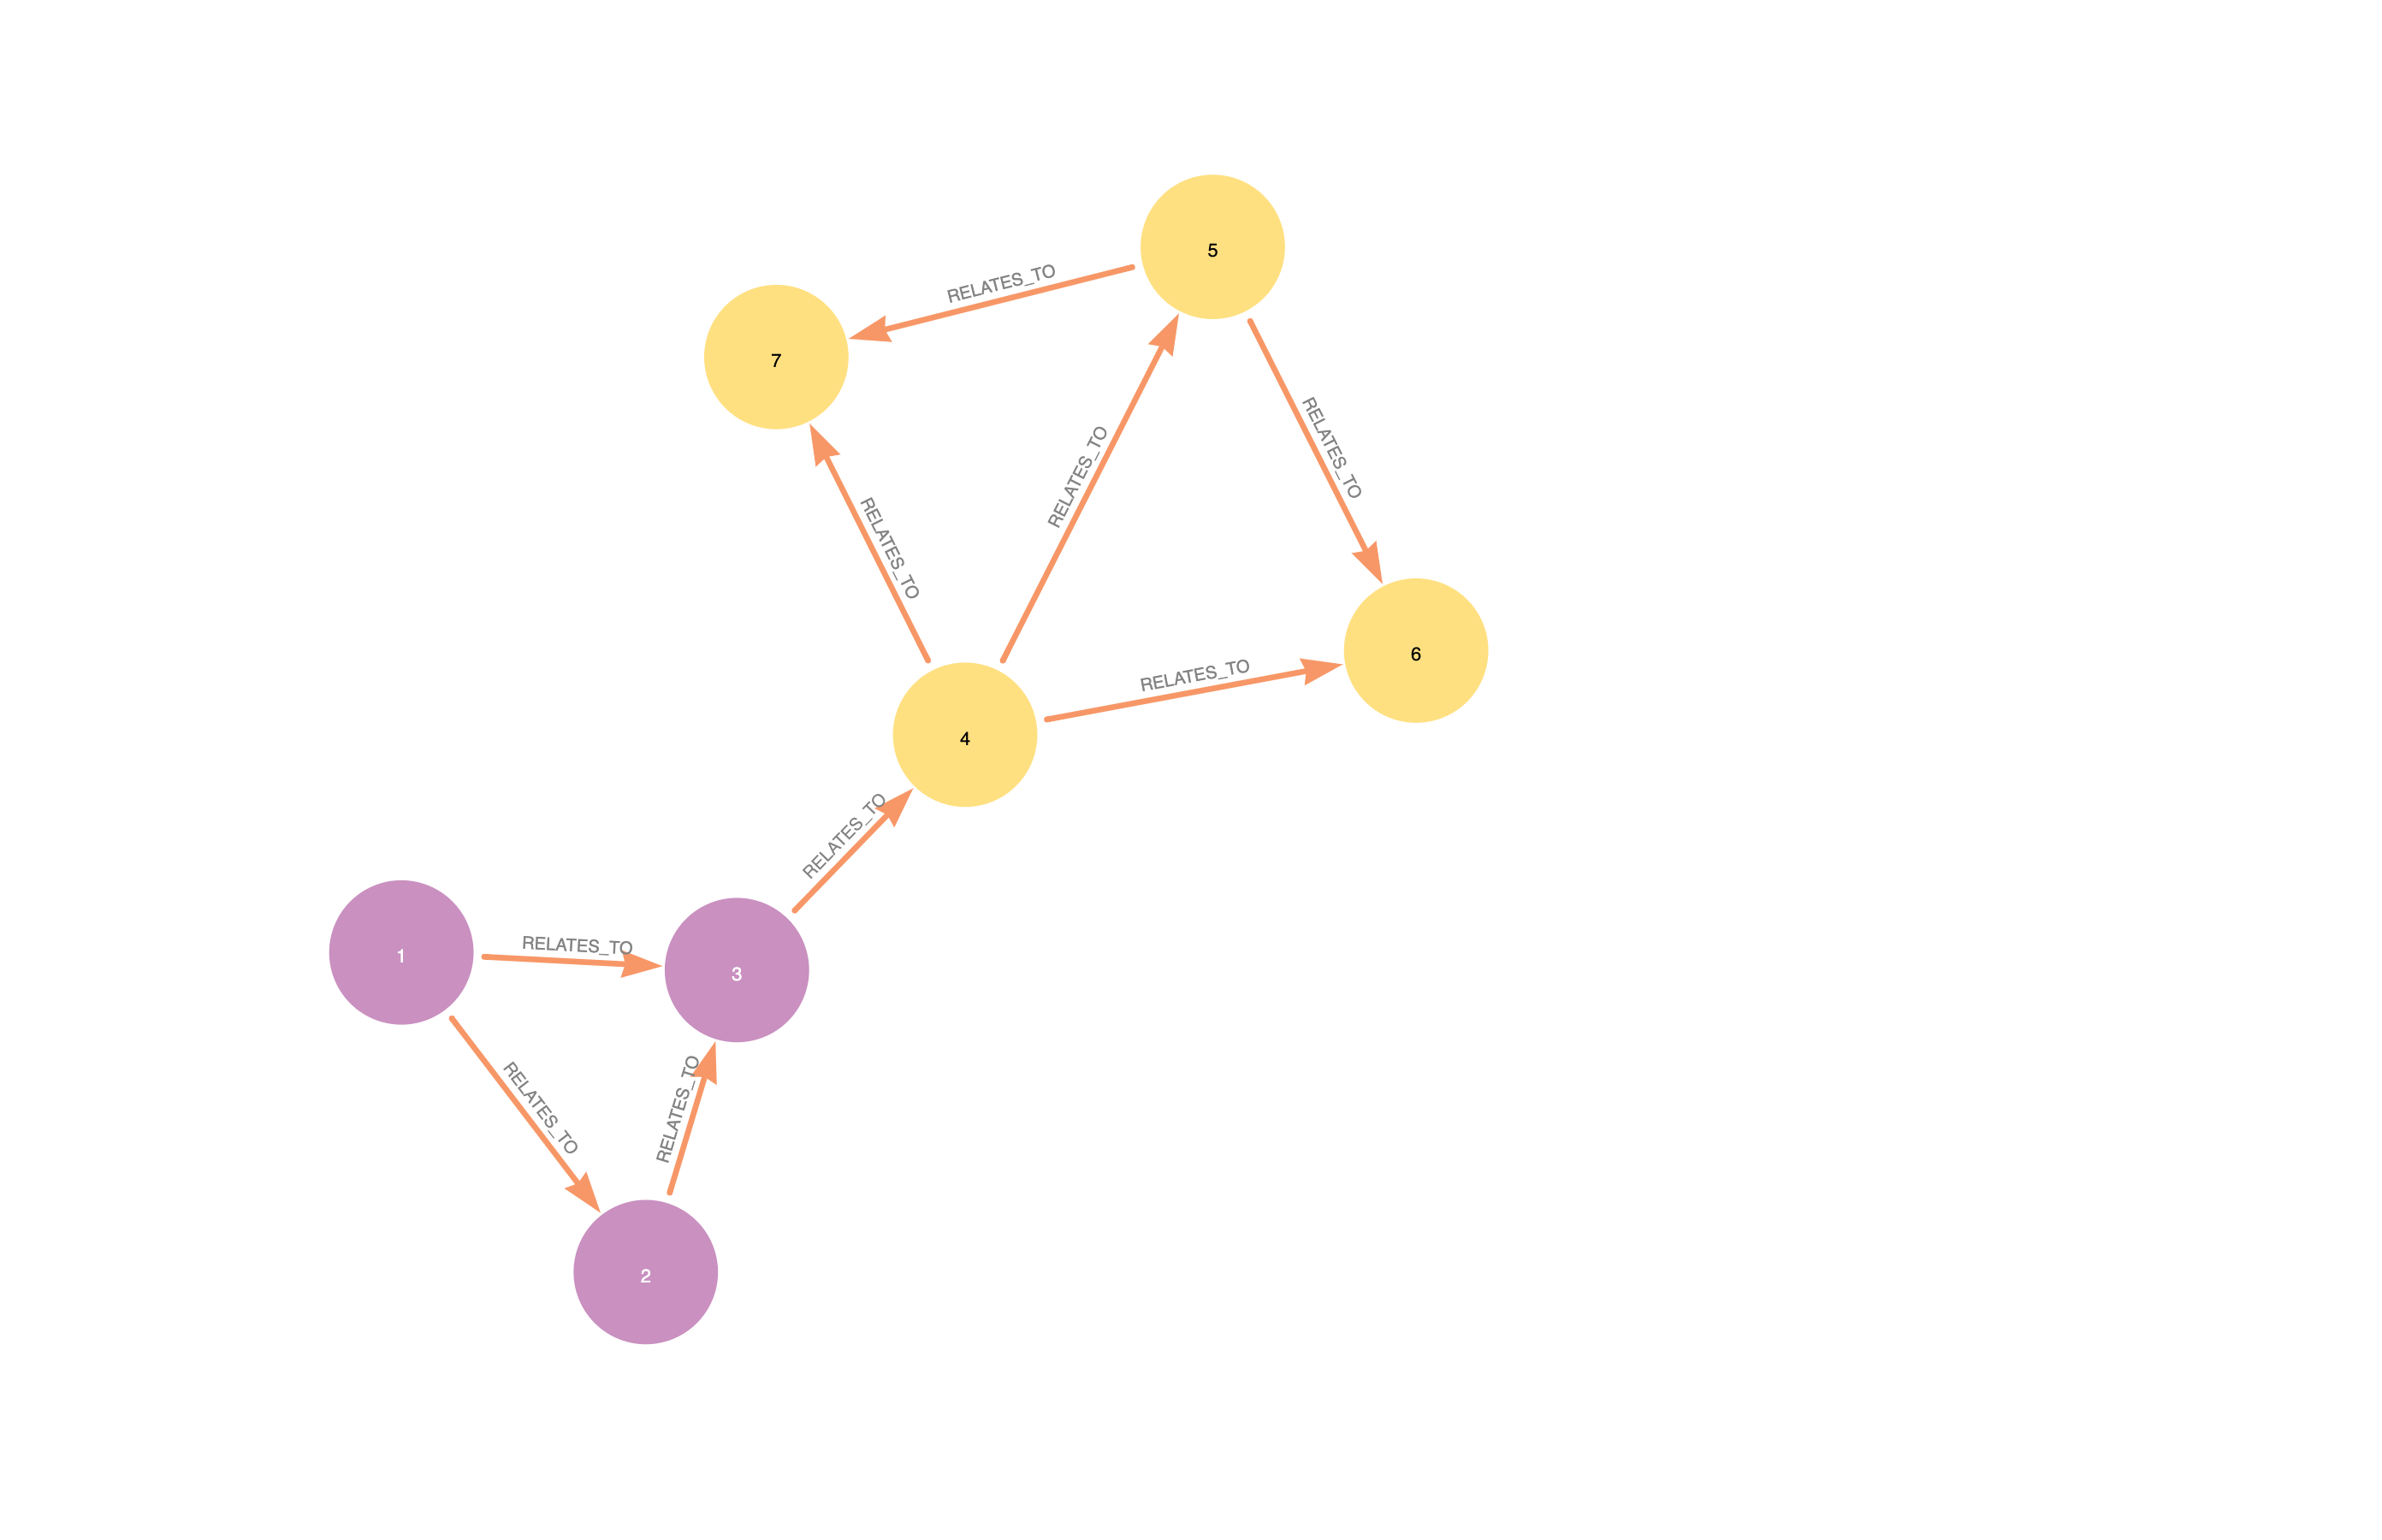

# Conductance
What percentage of relationships that start in one community end in a different community? Conductance can range between 0.0 and 1.0. The lower the conductance, the more isolated a community is from the rest of the graph.

## Calculate with Cypher

In [7]:
gds.run_cypher("""
MATCH (s)-[r:RELATES_TO]-(t)
WITH s.cluster AS cluster, 
SUM(CASE WHEN s.cluster <> t.cluster THEN 1 ELSE 0 END) AS differentCluster, 
COUNT(*) AS totalRels
RETURN differentCluster, totalRels, toFloat(differentCluster)/totalRels as conductance
""")

,differentCluster,totalRels,conductance
0,1,7,0.142857
1,1,11,0.090909


## Calculate conductance with GDS
Our Cypher calculation worked fine for a toy graph, but let's see how to use GDS to calculate the metric efficinetly on larger graphs.

Create an in-memory graph projection called "toy". Include all nodes with the `Node` label and their `cluster` properties. Project the `RELATES_TO` relationship as undirected.

In [8]:
G_toy, result = gds.graph.project("toy", 
                                 {"Node": {"properties":"cluster"}}, 
                                 {"RELATES_TO": {"orientation":"UNDIRECTED"}})

Call the conductance algorithm.

In [9]:
gds.alpha.conductance.stream(G_toy, communityProperty="cluster")

,community,conductance
0,1,0.142857
1,2,0.090909


# Modularity
What is the difference between the fraction of within-cluster relationships that we observe versus what we would see if nodes kept the same degree, but the relationships were connected randomly? Modularity can range between -0.5 and 1. The higher the modularity, the more our communities are cohesive and separate from the rest of the graph.

## Calculate with Cypher

### Get stubs and create random edges
Split relationships in half to create two stubs connected to the endpoints of the relationship.

Reconnect each stub to a random other available stub to create new relationships.

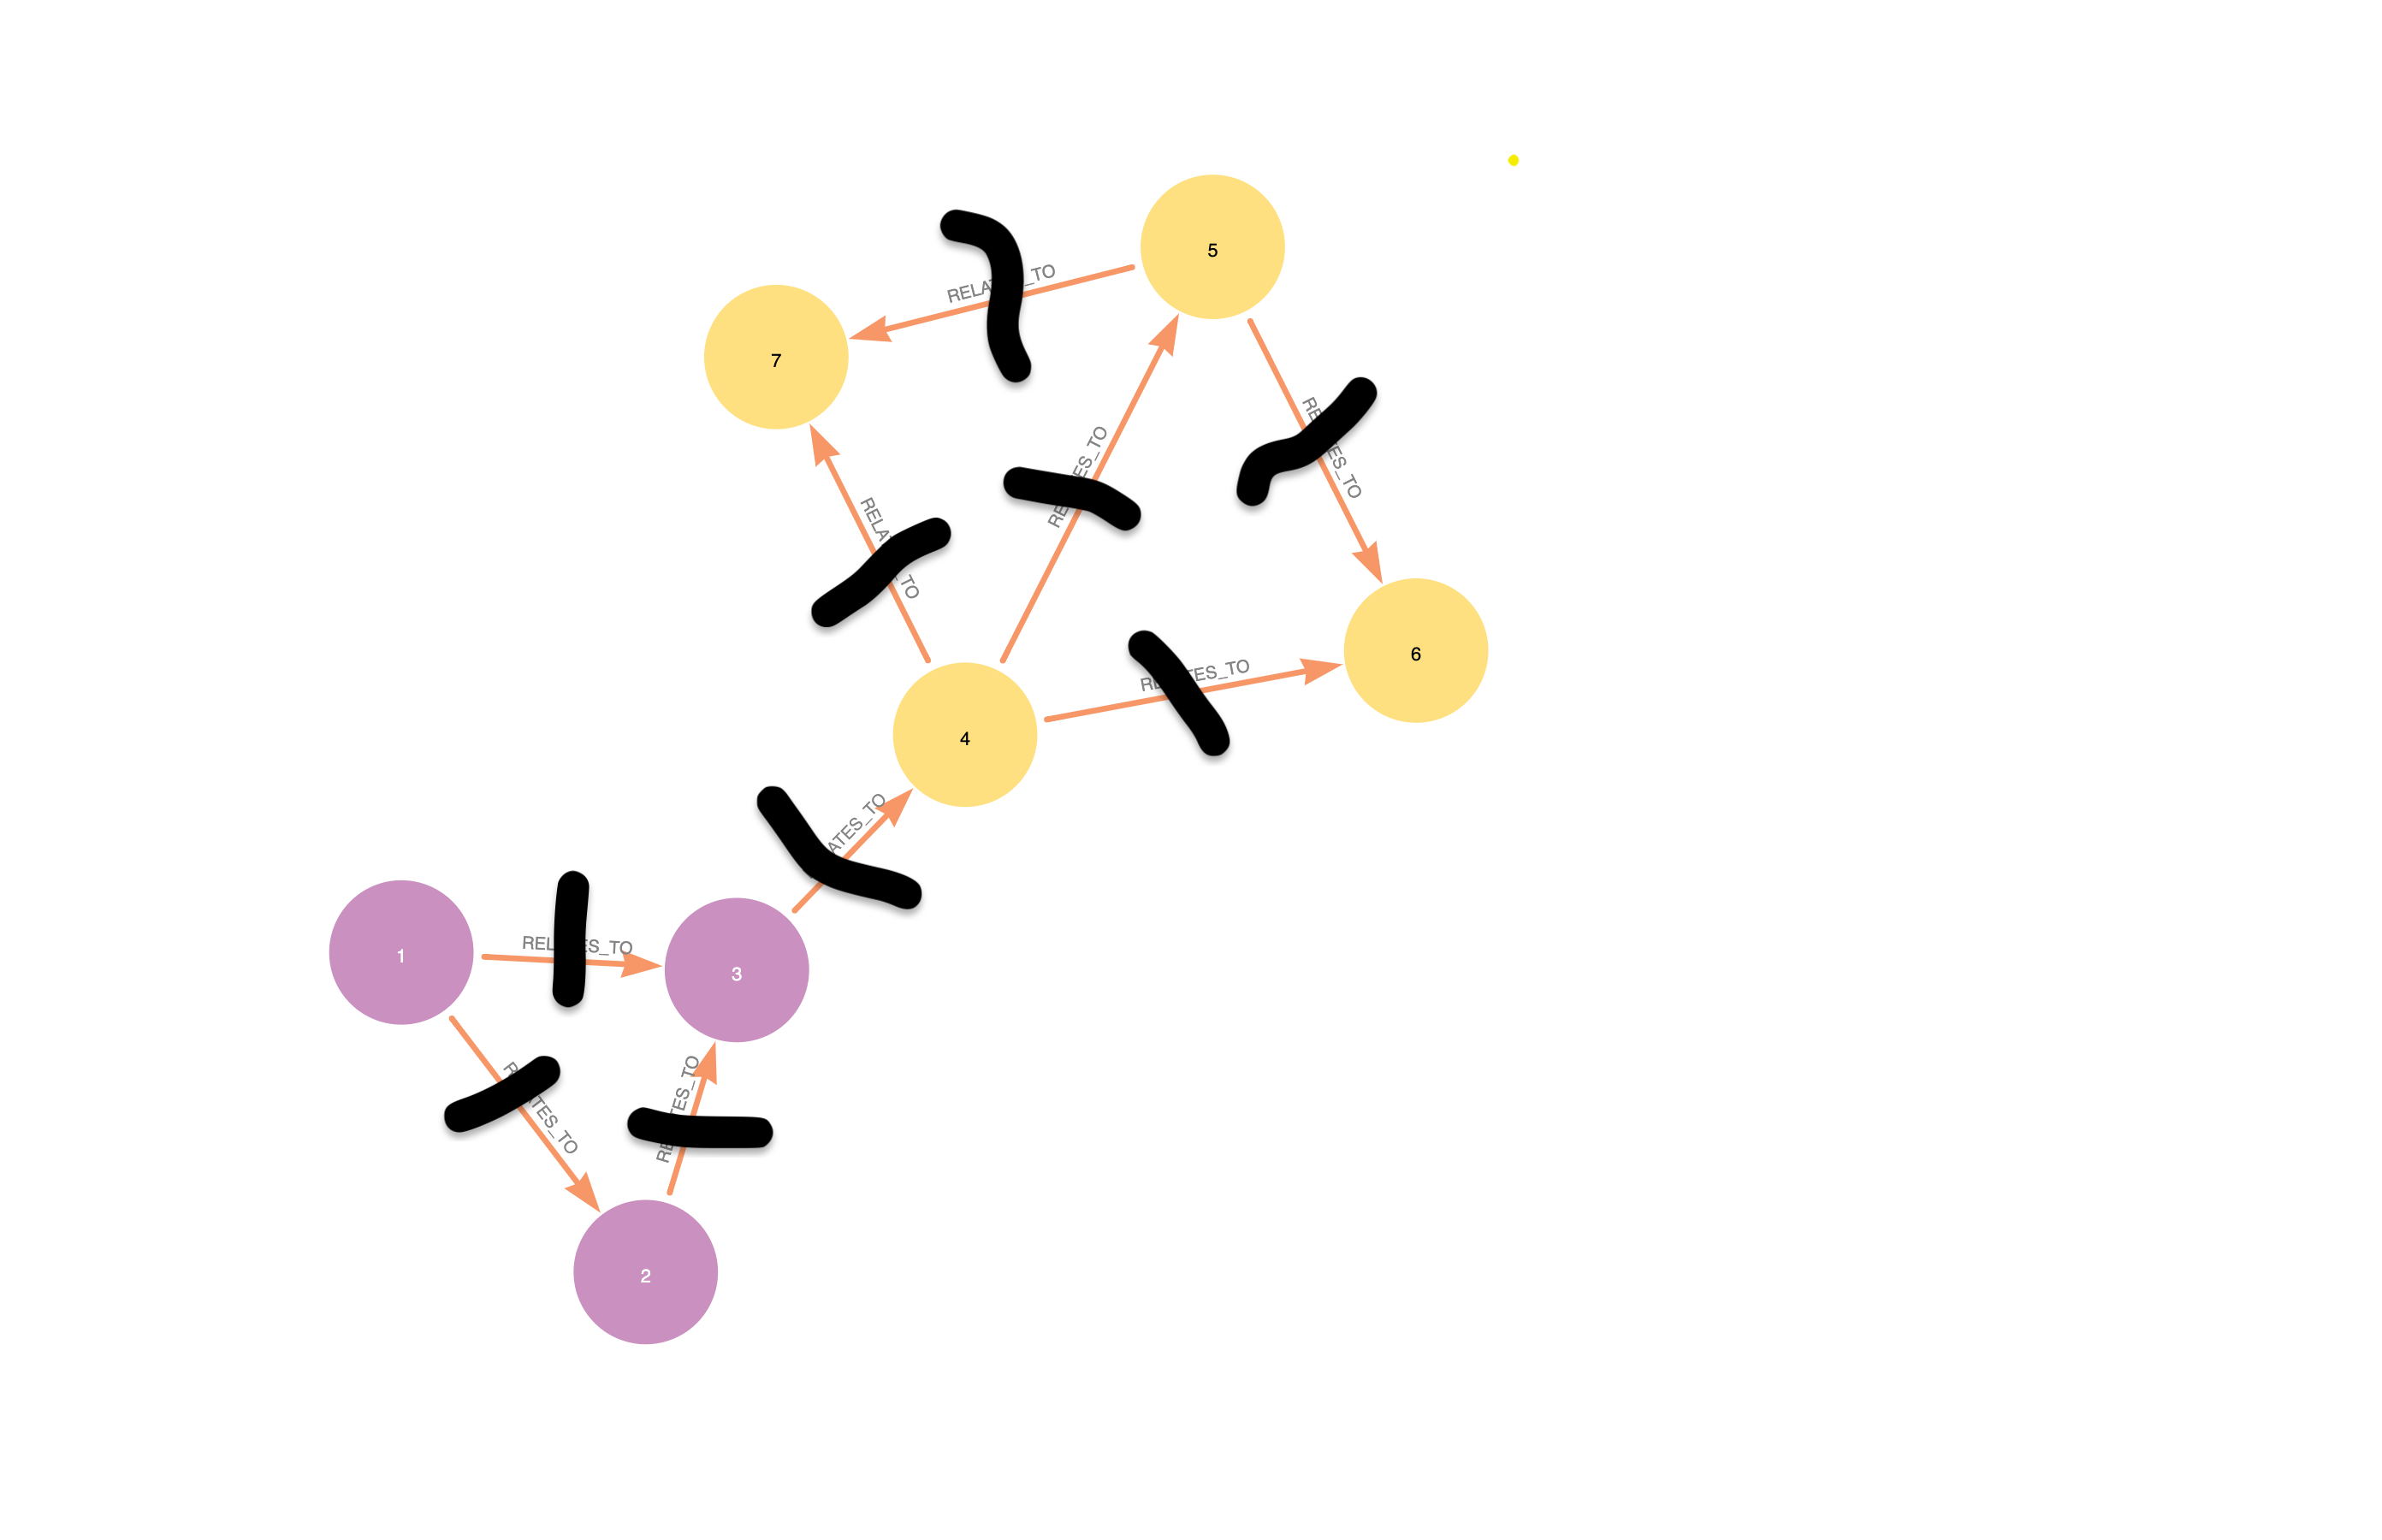

This query is complex, so we'll start simply and build up the final query step by step.

First, get all the relationships with their start and end node ids.

In [10]:
gds.run_cypher("""
MATCH (s)-[:RELATES_TO]->(t)
RETURN s.id as startId, t.id as endId
""")

,startId,endId
0,1,3
1,1,2
2,2,3
3,3,4
4,4,7
5,4,6
6,4,5
7,5,7
8,5,6


Add on to the prior query by unpivoting the start and end ids into a single column called stubId.

In [11]:
gds.run_cypher("""
MATCH (s)-[r:RELATES_TO]->(t)
UNWIND [s, t] as stub
RETURN stub.id as stubId
""")

,stubId
0,1
1,3
2,1
3,2
4,2
5,3
6,3
7,4
8,4
9,7


Sort the stubs in random order, and then collect them into a list.

In [12]:
gds.run_cypher("""
MATCH (s)-[:RELATES_TO]->(t)
UNWIND [s, t] as stub
WITH stub ORDER BY rand()
RETURN collect(stub.id) as stubs""")

,stubs
0,"[5, 3, 2, 6, 7, 4, 5, 7, 6, 4, 3, 2, 5, 4, 4, ..."


Select consecutive pairs of nodes from the stubs list to be the new relationship sources and targets.

In [13]:
gds.run_cypher("""
MATCH (s)-[r:RELATES_TO]->(t)
UNWIND [s, t] as stub
WITH stub ORDER BY rand()
WITH collect(stub) as stubs
UNWIND range(0, (size(stubs))/2 - 1) as i
RETURN stubs[i*2].id as source, stubs[i*2+1].id as target""")

,source,target
0,7,7
1,4,6
2,3,3
3,1,3
4,4,5
5,4,5
6,6,2
7,5,1
8,4,2


Create new RANDOM_EDGE relationships in the graph.

In [15]:
gds.run_cypher("""
MATCH (s)-[:RELATES_TO]->(t)
UNWIND [s, t] as stub
WITH stub ORDER BY rand()
WITH collect(stub) as stubs
UNWIND range(0, size(stubs)/2 - 1) as i
WITH stubs[i*2] as source, stubs[i*2+1] as target
CREATE (source)-[:RANDOM_EDGE]->(target)
RETURN source.id, target.id
""")

,source.id,target.id
0,7,6
1,5,7
2,5,1
3,1,4
4,3,6
5,3,4
6,3,2
7,5,4
8,4,2


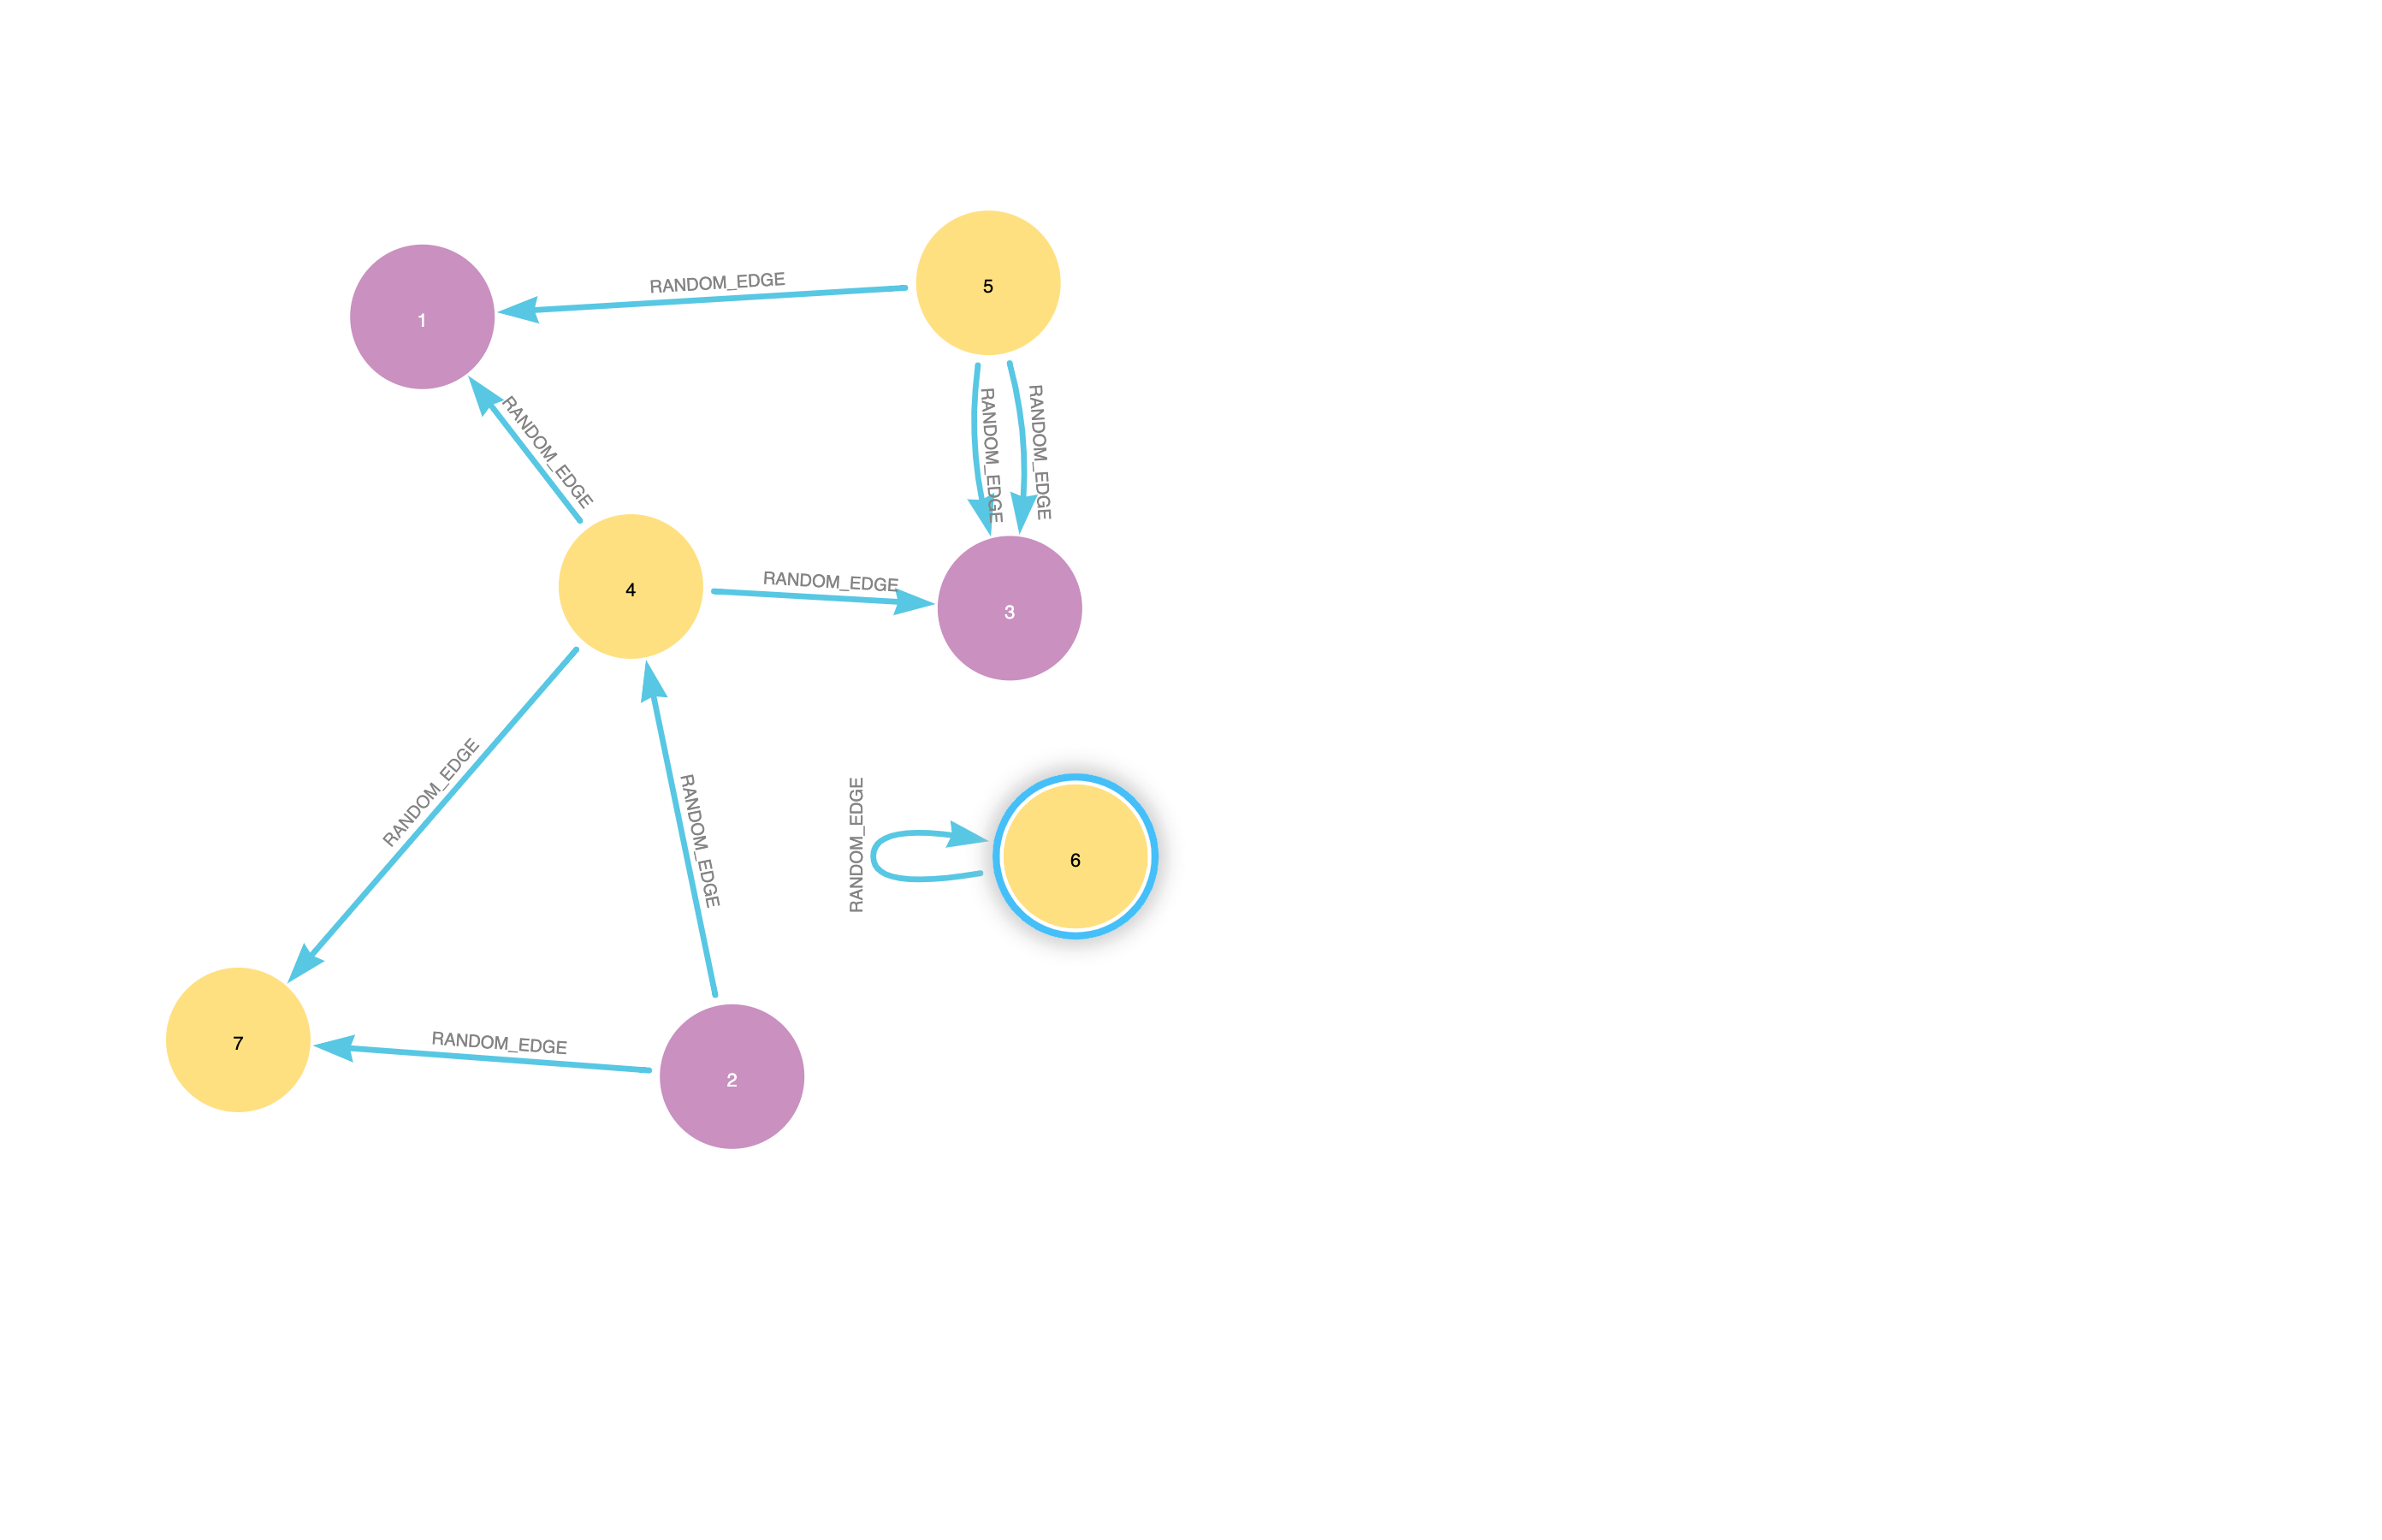

### Calculate modularity
Count the total number of undirected relationships in the graph by counting directed relationships and multiplying by 2.

In [16]:
gds.run_cypher("""MATCH (s)-[:RELATES_TO]->(t) RETURN count(*) * 2 as totalRelationships""")

,totalRelationships
0,18


Count the number of undirected RELATES_TO relationships where the start node and end node belong to the same cluster.

In [18]:
gds.run_cypher("""
MATCH (s)-[:RELATES_TO]->(t)
WHERE s.cluster = t.cluster
RETURN count(*) * 2 as withinClusterEdges
""")

,withinClusterEdges
0,16


Count the number of undirected RANDOM_EDGE relationships where the start and end node belong to the same cluster.

In [19]:
gds.run_cypher("""
MATCH (s)-[:RANDOM_EDGE]->(t)
WHERE s.cluster = t.cluster
RETURN count(*) * 2 as withinClusterRandomEdges
""")

,withinClusterRandomEdges
0,8


Subtract the proportion of within-cluster random edges from the proportion of within-cluster original edges to get modularity.

In [20]:
16.0/18.0 - 8.0/18.0

0.4444444444444444

This is fine, but there is no guarantee that the number will come out the same every time, because the random edges are assigned *randomly*. Let's create a function that can this code many times and look at the distribution of the results.

In [21]:
def calc_modularity_example():
    # Delete the old random edges
    gds.run_cypher("MATCH ()-[r:RANDOM_EDGE]->() DELETE r")
    # Create new random edges
    gds.run_cypher("""
        MATCH (s)-[:RELATES_TO]->(t)
        UNWIND [s, t] as stub
        WITH stub ORDER BY rand()
        WITH collect(stub) as stubs
        UNWIND range(0, size(stubs)/2 - 1) as i
        WITH stubs[i*2] as source, stubs[i*2+1] as target
        CREATE (source)-[:RANDOM_EDGE]->(target)""")
    # Count the in-cluster random edges
    random_edge_in_cluster_df = gds.run_cypher("""
        MATCH (s)-[:RANDOM_EDGE]->(t)
        WHERE s.cluster = t.cluster
        RETURN count(*) * 2 as withinClusterRandomEdges
        """)
    in_cluster_edges = random_edge_in_cluster_df.loc[0, "withinClusterRandomEdges"]
    # Calculate modularity
    return 16.0/18.0 - in_cluster_edges/18.0

Run the function a few times.

In [22]:
calc_modularity_example()

0.2222222222222222

In [23]:
calc_modularity_example()

0.4444444444444444

Run the function 100 times and summarize the results.

In [24]:
samples = [calc_modularity_example() for i in range(0, 100)]

In [25]:
sample_series = pd.Series(samples)

In [26]:
sample_series.value_counts()

0.444444    54
0.222222    33
0.666667    13
dtype: int64

<AxesSubplot:>

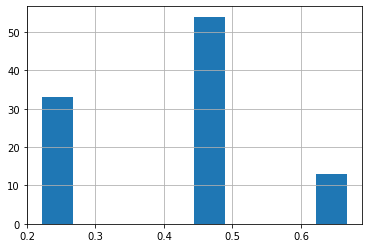

In [27]:
sample_series.hist()

In [28]:
sample_series.mean()

0.39999999999999936

## Calculate modularity with GDS

The Louvain algorithm in GDS will both assign nodes to communities and calculate the modularity of the partition. Run it in stats mode to see the modularity.

In [29]:
gds.louvain.stats(G_toy)

modularity                                                        0.364198
modularities                                          [0.3641975308641975]
ranLevels                                                                1
communityCount                                                           2
communityDistribution    {'p99': 4, 'min': 3, 'max': 4, 'mean': 3.5, 'p...
postProcessingMillis                                                     1
preProcessingMillis                                                      0
computeMillis                                                           59
configuration            {'maxIterations': 10, 'seedProperty': None, 'c...
Name: 0, dtype: object

View the clusters that result from calling Louvain.

In [45]:
gds.louvain.stream(G_toy)

,nodeId,communityId,intermediateCommunityIds
0,0,1,None
1,1,1,None
2,2,1,None
3,3,5,None
4,4,5,None
5,5,5,None
6,6,5,None


# Clustering Coefficient
What is the probability that two neighbors of a node also have a relationship between them? Clustering coefficient can range between 0 and 1. We average the local clustering coefficient across all nodes in the graph or subgraph. The higher the clustering coefficient, the more interconnected the nodes in the graph are.

## Calculate with Cypher

Start by calculating local clustering coefficient for each node in the graph.

In [30]:
gds.run_cypher("""
    MATCH (n1)-[:RELATES_TO]-(t)-[:RELATES_TO]-(n2)
    WHERE id(n1) < id(n2)
    OPTIONAL MATCH (n1)-[r:RELATES_TO]-(n2)
    WITH t, count(*) as neighborPairs, count(r) as relatedNeighbors
    RETURN t.id as nodeId, neighborPairs, relatedNeighbors, 
    toFloat(relatedNeighbors)/neighborPairs as localClusteringCoefficinet
    """)

,nodeId,neighborPairs,relatedNeighbors,localClusteringCoefficinet
0,3,3,1,0.333333
1,2,1,1,1.000000
2,1,1,1,1.000000
3,7,1,1,1.000000
4,6,1,1,1.000000
5,4,6,2,0.333333
6,5,3,2,0.666667


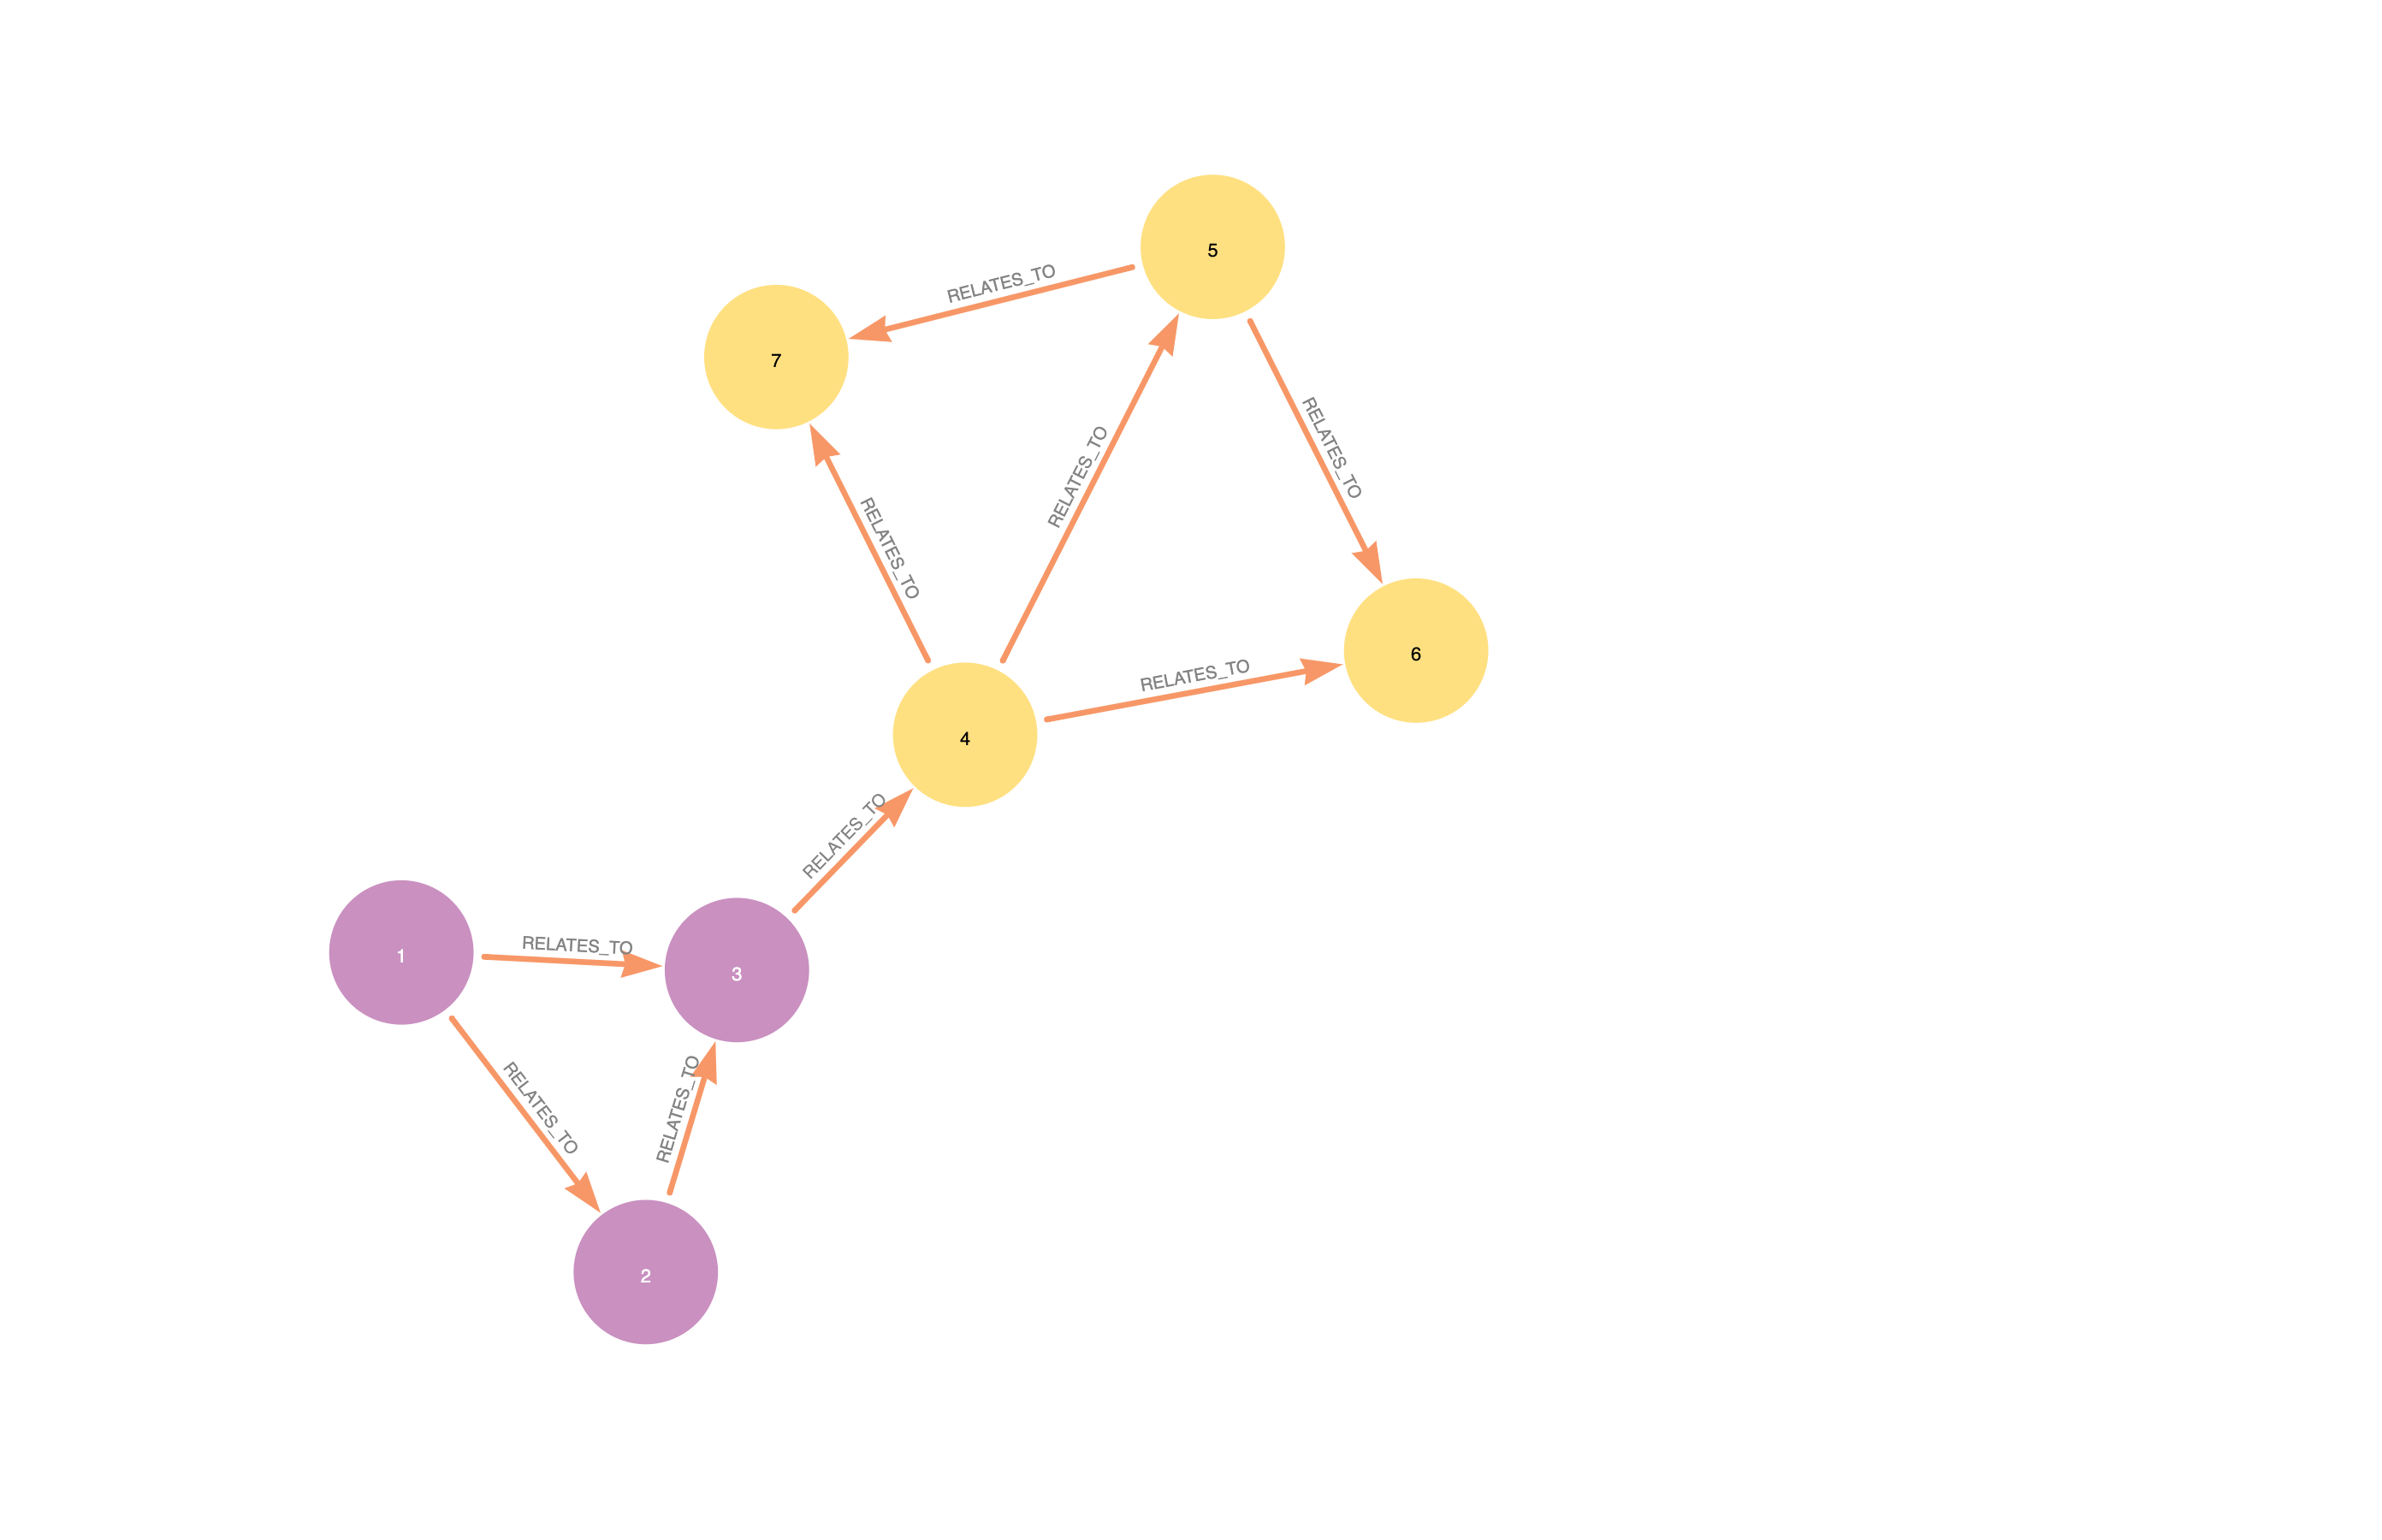

Now calculate the within-community clustering coefficient.

In [31]:
gds.run_cypher("""
    MATCH (n1)-[:RELATES_TO]-(t)-[:RELATES_TO]-(n2)
    WHERE id(n1) < id(n2)
    AND t.cluster = n1.cluster
    AND t.cluster = n2.cluster
    OPTIONAL MATCH (n1)-[r:RELATES_TO]-(n2)
    WITH t, count(*) as neighborPairs, count(r) as relatedNeighbors
    RETURN t.cluster as cluster, t.id as nodeId, neighborPairs, relatedNeighbors, 
    toFloat(relatedNeighbors)/neighborPairs as localClusteringCoefficinet
    order by cluster, nodeId
    """)

,cluster,nodeId,neighborPairs,relatedNeighbors,localClusteringCoefficinet
0,1,1,1,1,1.000000
1,1,2,1,1,1.000000
2,1,3,1,1,1.000000
3,2,4,3,2,0.666667
4,2,5,3,2,0.666667
5,2,6,1,1,1.000000
6,2,7,1,1,1.000000


Modify the previous query to calculate the average for each cluster.

In [32]:
gds.run_cypher("""
    MATCH (n1)-[:RELATES_TO]-(t)-[:RELATES_TO]-(n2)
    WHERE id(n1) < id(n2)
    AND t.cluster = n1.cluster
    AND t.cluster = n2.cluster
    OPTIONAL MATCH (n1)-[r:RELATES_TO]-(n2)
    WITH t, count(*) as neighborPairs, count(r) as relatedNeighbors
    WITH t.cluster as cluster, 
    toFloat(relatedNeighbors)/neighborPairs as localClusteringCoefficinet
    RETURN cluster, avg(localClusteringCoefficinet) as localClusteringCoefficient
    """)

,cluster,localClusteringCoefficient
0,1,1.000000
1,2,0.833333


## Calculate with GDS

Get the average local clustering coefficient across the whole graph by calling localClusteringCoefficient in stats mode.

In [34]:
gds.localClusteringCoefficient.stats(G_toy)

averageClusteringCoefficient                                             0.761905
nodeCount                                                                       7
postProcessingMillis                                                            0
preProcessingMillis                                                             2
computeMillis                                                                   7
configuration                   {'triangleCountProperty': None, 'nodeLabels': ...
Name: 0, dtype: object

Now let's get the clustering coefficinet within each community. Get the cluster IDs. (This is no big deal for our toy, but in a bigger graph the IDs might not be so easy to remember.)

In [35]:
cluster_ids = gds.graph.streamNodeProperty(G_toy, "cluster")

In [36]:
cluster_ids

,nodeId,propertyValue
0,0,1
1,1,1
2,2,1
3,3,2
4,4,2
5,5,2
6,6,2


Rename the propertyValue column to cluster and drop the duplicate values for the cluster column.

In [37]:
cluster_ids.rename({'propertyValue':'cluster'}, axis=1, inplace=True)
cluster_ids.drop_duplicates("cluster", inplace=True)
cluster_ids

,nodeId,cluster
0,0,1
3,3,2


Create a little function to create a subgraph for based on nodes with that cluster ID.

In [38]:
def project_cluster_subgraph(cluster_id):
    subgraph, result = gds.beta.graph.project.subgraph(f"cluster_{cluster_id}", 
                                                       G_toy, 
                                                       f"n.cluster = {cluster_id}", 
                                                       "*")
    return subgraph

Run the projection function for each row in the dataframe.

In [39]:
cluster_ids['subgraph'] = cluster_ids['cluster'].map(project_cluster_subgraph)

In [40]:
cluster_ids

,nodeId,cluster,subgraph
0,0,1,<graphdatascience.graph.graph_object.Graph obj...
3,3,2,<graphdatascience.graph.graph_object.Graph obj...


Run the localClusteringCoefficient function for each row in the dataframe.

In [41]:
cluster_ids['averageClusteringCoefficient'] = (
    cluster_ids['subgraph'].map(lambda x: gds.localClusteringCoefficient.stats(x)['averageClusteringCoefficient']))

In [42]:
cluster_ids

,nodeId,cluster,subgraph,averageClusteringCoefficient
0,0,1,<graphdatascience.graph.graph_object.Graph obj...,1.000000
3,3,2,<graphdatascience.graph.graph_object.Graph obj...,0.833333


# Evaluate clusters based on property values instead of relationships
Neo4j GDS 2.1.0 (releasing soon) includes the KMeans clustering algorithm, which uses node property values to assign graphs to clusters. Measures of community quality based on relationships might or might not apply to these clusters. You can use traditional cluster quality measures like silhouette score to evaluate the quality of these clusters.

## Use the FastRP node embedding algorithm to create vectors for each node.

In [53]:
gds.fastRP.mutate(G_toy, embeddingDimension=8, mutateProperty = "fastRPEmbedding")

nodePropertiesWritten                                                    7
mutateMillis                                                             0
nodeCount                                                                7
preProcessingMillis                                                      0
computeMillis                                                            2
configuration            {'nodeSelfInfluence': 0, 'relationshipWeightPr...
Name: 0, dtype: object

Calculate clusters using the K-Means algorithm. This algorithm is included in GDS 2.1 which is now in preview.

In [54]:
gds.alpha.kmeans.mutate(G_toy, nodeProperty = "fastRPEmbedding", mutateProperty = "kMeansCluster", k=2)

mutateMillis                                                             0
nodePropertiesWritten                                                    7
communityDistribution    {'p99': 4, 'min': 3, 'max': 4, 'mean': 3.5, 'p...
postProcessingMillis                                                     3
preProcessingMillis                                                      0
computeMillis                                                            2
configuration            {'nodeProperty': 'fastRPEmbedding', 'maxIterat...
Name: 0, dtype: object

In [55]:
cluster_results = gds.graph.streamNodeProperties(G_toy, ["fastRPEmbedding", "kMeansCluster"])

In [56]:
cluster_results

,nodeId,nodeProperty,propertyValue
0,0,fastRPEmbedding,"[0.732131838798523, -0.06748043745756149, 0.74..."
1,0,kMeansCluster,0
2,1,fastRPEmbedding,"[0.8350645303726196, 0.09008433669805527, 0.60..."
3,1,kMeansCluster,0
4,2,fastRPEmbedding,"[0.49977952241897583, 0.005832098890095949, 0...."
5,2,kMeansCluster,0
6,3,fastRPEmbedding,"[-0.4709336757659912, 0.0, 0.4231370687484741,..."
7,3,kMeansCluster,1
8,4,fastRPEmbedding,"[-0.6600412130355835, 0.0, 0.22160130739212036..."
9,4,kMeansCluster,1


In [57]:
cluster_results = cluster_results.pivot(index="nodeId", columns="nodeProperty", values="propertyValue")

In [58]:
cluster_results

nodeProperty,fastRPEmbedding,kMeansCluster
nodeId,,
0,"[0.732131838798523, -0.06748043745756149, 0.74...",0
1,"[0.8350645303726196, 0.09008433669805527, 0.60...",0
2,"[0.49977952241897583, 0.005832098890095949, 0....",0
3,"[-0.4709336757659912, 0.0, 0.4231370687484741,...",1
4,"[-0.6600412130355835, 0.0, 0.22160130739212036...",1
5,"[-0.7808382511138916, 0.0, 0.3129851818084717,...",1
6,"[-0.7808382511138916, 0.0, 0.3129851818084717,...",1


Silhouette score compares the disteance from sample to other nodes in the came cluster with the distance from that sample to the nodes in the next-closest closer. The best possible score is 1, and the worst possible score is -1. See the definition of Silhouette score in the [sci-kit learn documentation](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient).

In [59]:
silhouette_score(list(cluster_results['fastRPEmbedding']), cluster_results['kMeansCluster'])

0.7995457832829859